# 3. Slide-seqV2 Hippocampus

Here, we analyzed the mouse hippocampus data generated from Slide-seqV2, which also included parts of the cortex and thalamus. The raw data are avaliable at https://singlecell.broadinstitute.org/.

## Load data

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import SECE
import torch
import numpy as np
import scanpy as sc

result_path = 'hippocampus'
os.makedirs(result_path, exist_ok=True)

In [2]:
adata = sc.read('./data/hippocampus.h5ad')
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=20)
adata

AnnData object with n_obs × n_vars = 51398 × 16235
    obs: 'x', 'y', 'n_genes'
    var: 'n_cells'
    obsm: 'spatial'
    layers: 'counts'

## Creating and training the model

In [3]:
sece = SECE.SECE_model(adata.copy(), 
                       likelihood='zinb',
                       result_path=result_path,
                       hvg=5000,
                       dropout_rate=0.1,
                       dropout_gat_rate=0.2,
                       device='cuda:0')

Likelihood: zinb
Input dim: 5000
Latent Dir: 32
Model1 dropout: 0.1
Model2 dropout: 0.2


In [4]:
sece.adata.X.toarray() # Count matrix

array([[1., 1., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 2., 0., ..., 0., 2., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Module1 of SECE

In [5]:
# Prepare input data for model1
sece.prepare_data(lib_size='explog', normalize=True, scale=False)

Library size: explog
Input normalize: True
Input scale: False
Hvg: 5000
(51398, 5000)


In [6]:
# train and predict for model1
sece.train_model1(epoch1=50, plot=True)
adata1 = sece.predict_model1()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:35<00:00,  6.72s/it]


Model1 lr: 0.001
Model1 epoch: 50
Model1 batch_size: 128


### Module2 of SECE

In [7]:
# Prepare input data for model2
sece.prepare_graph(cord_keys=['x','y'], 
                   latent_key = 'X_CE',
                   num_batch_x=2, 
                   num_batch_y=3, 
                   neigh_cal='knn',
                   n_neigh=10, 
                   kernal_thresh=0.5)

Batch 1: Each cell have 10.0 neighbors
Batch 1: Each cell have 59similar cells
Batch 2: Each cell have 10.0 neighbors
Batch 2: Each cell have 59similar cells
Batch 3: Each cell have 10.0 neighbors
Batch 3: Each cell have 59similar cells
Batch 4: Each cell have 10.0 neighbors
Batch 4: Each cell have 59similar cells
Batch 5: Each cell have 10.0 neighbors
Batch 5: Each cell have 59similar cells
Batch 6: Each cell have 10.0 neighbors
Batch 6: Each cell have 60similar cells
All: Each cell have 10.0 neighbors
Graph cal: knn
knn: 10
kernal_thresh: 0.5


In [8]:
# train and predict for model2
sece.train_model2(  lr_gat=0.01, 
                    epoch2=40, 
                    re_weight=1, 
                    si_weight=0.08, 
                    plot=True)
adata1 = sece.predict_model2()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.61it/s]


Model2 lr: 0.01
Model2 epoch: 40
Model2 similar weight: 0.08


## Spatial domains

### Clustering for SE

In [9]:
sc.pp.neighbors(adata1, use_rep='X_SE', key_added='X_SE')
adata1.obsm['umap_SE'] = sc.tl.umap(adata1, neighbors_key='X_SE', copy=True).obsm['X_umap']
SECE.cluster_func(adata1, clustering='mclust', use_rep='X_SE', cluster_num=14, key_add='layer_cluster')

VSCode R Session Watcher requires jsonlite, rlang. Please install manually in order to use VSCode-R.
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 51398 × 5000
    obs: 'x', 'y', 'n_genes', 'size', 'n_counts', 'layer_cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'X_SE'
    obsm: 'spatial', 'X_CE', 'X_SE', 'umap_SE'
    layers: 'counts', 'expr'
    obsp: 'X_SE_distances', 'X_SE_connectivities'

### Visualization of spatial domains

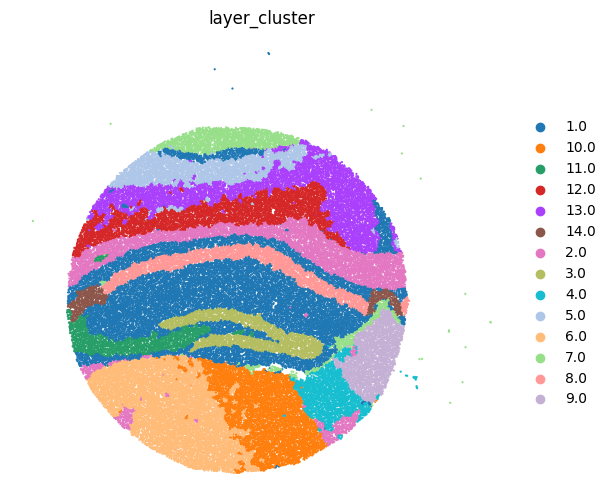

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (6.5,6)}):
    sc.pl.embedding(adata1, basis='spatial', color=['layer_cluster'],
                    frameon=False, show=False, s=10)

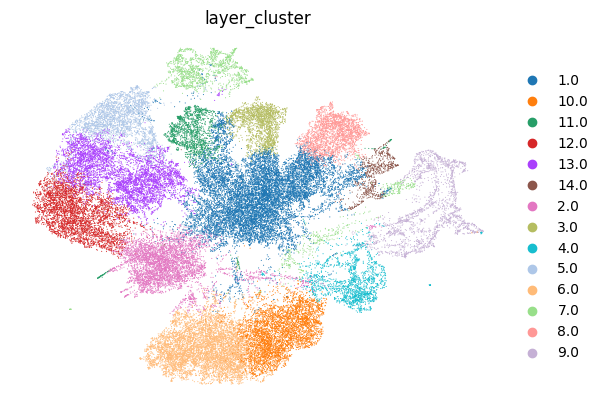

In [11]:
sc.pl.embedding(adata1, basis='umap_SE', color=['layer_cluster'], frameon=False)

In [12]:
adata1

AnnData object with n_obs × n_vars = 51398 × 5000
    obs: 'x', 'y', 'n_genes', 'size', 'n_counts', 'layer_cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'X_SE', 'layer_cluster_colors'
    obsm: 'spatial', 'X_CE', 'X_SE', 'umap_SE'
    layers: 'counts', 'expr'
    obsp: 'X_SE_distances', 'X_SE_connectivities'

In [13]:
adata1.write(f'{result_path}/adata1.h5ad')